In [3]:
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import seaborn as sns

import sys
sys.path.insert(0,'/home/gsoc0/Adversarial_CapsNet_Pytorch/')
from model.net import *
from model.cnn_net import *
from utils.training import *
from data.data import *

## Experiment Config

In [4]:
model_path = os.path.join(os.getcwd(), "weights")

args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 512,
#     'N_EPOCHS': 100,
#     'LEARNING_RATE_1': 1e-2,
#     'LEARNING_RATE_2': 1e-2,
#     'WEIGHTDECAY':5e-6,
#     #Scheduler
#     'USE_SCHEDULER':True,
#     'sched_milestones':[14,25,30,40,50],
#     'sched_gamma':0.1,
    
#     #Loss Function
#     'LAMBDA_recon': 0.5,
#     'LAMBDA_class': 1,
    
    ##For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,    
}

#Setting Default Cuda Device
torch.cuda.set_device(0)

## Model Loading

In [3]:
#Modified Reconstructor

class Reconstructor(nn.Module):
    def __init__(self, net, args):
        super(Reconstructor, self).__init__()
        self.args = args
        self.reconstraction_layers = net.decoder.reconstraction_layers
        self.mean = torch.tensor(0.1307)
        self.std = torch.tensor(0.3081)
        if(args['USE_CUDA']):
            self.mean = self.mean.cuda()
            self.std = self.std.cuda()
        self.unnormalize = UnNormalize(self.mean, self.std)
        
    def forward(self, x, data):
        with torch.no_grad():
            classes = torch.sqrt((x ** 2).sum(2))
            classes = F.softmax(classes.squeeze(), dim=1)
            _, max_length_indices = classes.max(dim=1)
            eye = torch.sparse.torch.eye(10)
            if USE_CUDA:
                eye = eye.cuda()
            reconstructions_of_digits = []
            list_of_indices = [max_length_indices]
            for i, index_list in enumerate(list_of_indices):
                masked = eye.index_select(dim=0, index=index_list.squeeze().data)
                reconstructions_of_digits.append(self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), 1, -1)))

            reconstructions_of_digits = torch.cat(reconstructions_of_digits, dim=1) 
            expanded_data = data.view(x.size(0), 1, -1).expand(-1, len(list_of_indices), -1)
            unnormalized_data = self.unnormalize(expanded_data)
            l2_distances = torch.square((unnormalized_data - reconstructions_of_digits)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
            return l2_distances
    
    def class_conditional_recon(self, x, data):
        with torch.no_grad():
            classes = torch.sqrt((x ** 2).sum(2))
            classes = F.softmax(classes.squeeze(), dim=1)
            _, max_length_indices = classes.max(dim=1)
            eye = torch.sparse.torch.eye(10)
            if USE_CUDA:
                eye = eye.cuda()
            reconstructions_of_digits = []
            list_of_indices = [max_length_indices]
            for i, index_list in enumerate(list_of_indices):
                masked = eye.index_select(dim=0, index=index_list.squeeze().data)
                reconstructions_of_digits.append(self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), 1, -1)))

            reconstructions_of_digits = torch.cat(reconstructions_of_digits, dim=1)
            expanded_data = data.view(x.size(0), 1, -1).expand(-1, len(list_of_indices), -1)
            unnormalized_data = self.unnormalize(expanded_data)
            l2_distances = torch.square((unnormalized_data - reconstructions_of_digits)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
            return l2_distances
    
def imshow(img):
#     img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.cpu().numpy()
#     plt.imshow(np.transpose(npimg)#, (1, 2, 0)))
    plt.imshow(npimg)
    plt.show()

In [4]:
class Config:
    def __init__(self, dataset='mnist'):
        # CNN (cnn)
        self.cnn_in_channels = 1
        self.cnn_out_channels = 12
        self.cnn_kernel_size = 15

        # Primary Capsule (pc)
        self.pc_num_capsules = 1
        self.pc_in_channels = 12
        self.pc_out_channels = 16
        self.pc_kernel_size = 8
        self.pc_num_routes = 7 * 7

        # Digit Capsule 1 (dc)
        self.dc_num_capsules = 49
        self.dc_num_routes = 7 * 7
        self.dc_in_channels = 16
        self.dc_out_channels = 16 #1
        
        # Digit Capsule 2 (dc)
        self.dc_2_num_capsules = 10
        self.dc_2_num_routes = 7 * 7
        self.dc_2_in_channels = 16 #1
        self.dc_2_out_channels = 16

        # Decoder
        self.input_width = 28
        self.input_height = 28
torch.manual_seed(1)
config = Config()

net = CapsNet(args, config)
# capsule_net = torch.nn.DataParallel(capsule_net)
if args['USE_CUDA']:
    net = net.cuda()
    
net.load_state_dict(torch.load(os.path.join(model_path, 'CapsNet_mnist.pth'), map_location='cpu'))

<All keys matched successfully>

## Loading Dataset

In [9]:
trainloader, testloader = dataset(args)
for data in trainloader:
    print(data[0][0].min())
    print(data[0][0].max())
    break

tensor(-0.4242)
tensor(2.8088)


##  Untargeted WhiteBox Attack for CapsuleNet

In [10]:
a = torch.tensor([], dtype=torch.int16)
b = torch.tensor([1,2,3], dtype=torch.int16)
torch.cat((a,b))

tensor([1, 2, 3], dtype=torch.int16)

In [11]:
import matplotlib.pyplot as plt
from advertorch.attacks import LinfPGDAttack, GradientSignAttack, CarliniWagnerL2Attack, LinfBasicIterativeAttack

class Model_for_Adversary(nn.Module):
    def __init__(self, net):
        super(Model_for_Adversary, self).__init__()
        self.net = net
        
    def forward(self, x):
        output, recons, masked = self.net(x)
        classes = torch.sqrt((output ** 2).sum(2)).squeeze()
        return classes
    
def WhiteBox_Attacks_Targeted(net, dataloader, adversary_dict, args):
    net.eval()
    n_batch = len(dataloader)
    Success_Rate = {key:0.0 for key in adversary_dict.keys()}
    Undetected_Rate = {key:0.0 for key in adversary_dict.keys()}
    Und_l2 = {key:torch.tensor([],dtype=torch.int16).cuda() for key in adversary_dict.keys()}
    for adversary in adversary_dict.keys():
        for batch_id, (data, labels) in enumerate(tqdm(dataloader)):
            target = torch.randint(0,10,size=(labels.size(0),), dtype=labels.dtype).cuda()
            if(args['USE_CUDA']):
                data, labels = data.cuda(), labels.cuda()
            adv_data = adversary_dict[adversary].perturb(data, target)
            with torch.no_grad():
                output, reconstructions, max_length_indices = net(adv_data)
                unnormalized_data = net.decoder.unnormalize(adv_data)
                l2_distances = ((reconstructions.view(adv_data.size(0),-1)-unnormalized_data.view(adv_data.size(0), -1))**2).sum(1).squeeze().detach()
                theta = np.percentile(l2_distances.cpu().numpy(), 95)
                if(adversary=='Clean'):
                    Und_l2[adversary] = torch.cat((Und_l2[adversary],l2_distances))
                else:
                    Und_l2[adversary] = torch.cat((Und_l2[adversary],l2_distances[max_length_indices == target]))
                Success_Rate[adversary]+=torch.sum(max_length_indices == target).item()
                Undetected_Rate[adversary]+=torch.sum(l2_distances[max_length_indices == target]<=theta).item()
        
        Und_l2[adversary] = Und_l2[adversary].cpu().numpy()
        Success_Rate[adversary]/=100
        Undetected_Rate[adversary]/=100
    return Success_Rate, Undetected_Rate, Und_l2

def WhiteBox_Attacks_Untargeted(net, dataloader, adversary_dict, args):
    net.eval()
    n_batch = len(dataloader)
    Success_Rate = {key:0.0 for key in adversary_dict.keys()}
    Undetected_Rate = {key:0.0 for key in adversary_dict.keys()}
    Und_l2 = {key:torch.tensor([],dtype=torch.int16).cuda() for key in adversary_dict.keys()}
    for adversary in adversary_dict.keys():
        for batch_id, (data, labels) in enumerate(tqdm(dataloader)):
            if(args['USE_CUDA']):
                data, labels = data.cuda(), labels.cuda()

            adv_data = adversary_dict[adversary].perturb(data)
            with torch.no_grad():
                output, reconstructions, max_length_indices = net(adv_data)
                unnormalized_data = net.decoder.unnormalize(adv_data)
                l2_distances = ((reconstructions.view(adv_data.size(0),-1)-unnormalized_data.view(adv_data.size(0), -1))**2).sum(1).squeeze().detach()
                theta = np.percentile(l2_distances.cpu().numpy(), 95)
                if(adversary=='Clean'):
                    Und_l2[adversary] = torch.cat((Und_l2[adversary],l2_distances))
                else:
                    Und_l2[adversary] = torch.cat((Und_l2[adversary],l2_distances[max_length_indices != labels]))
                Success_Rate[adversary]+=torch.sum(max_length_indices != labels).item()
                Undetected_Rate[adversary]+=torch.sum(l2_distances[max_length_indices!=labels]<=theta).item()
#                 print(Success_Rate[adversary])
#                 print(Undetected_Rate[adversary])
#                 print(theta)
        Und_l2[adversary] = Und_l2[adversary].cpu().numpy() 
        Success_Rate[adversary]/=100
        Undetected_Rate[adversary]/=100
    return Success_Rate, Undetected_Rate, Und_l2

In [12]:
from advertorch.attacks.base import Attack, LabelMixin
from advertorch.utils import clamp

class CleanAttack(Attack, LabelMixin):
    def __init__(self, clip_min=0., clip_max=1.):
        super(CleanAttack, self).__init__(None,None,clip_min, clip_max)

    def perturb(self, x, y=None):
        return x
    
def Attack_Table(L2_Distances, theta_percentile):
    theta = np.percentile(L2_Distances['Clean'], theta_percentile)
    Success_Rate = {key:0.0 for key in L2_Distances.keys()}
    Undetected_Rate = {key:0.0 for key in L2_Distances.keys()}
    for adversary in L2_Distances.keys():
        Success_Rate[adversary] = L2_Distances[adversary].shape[0]/ 100
        Undetected_Rate[adversary] = np.sum(L2_Distances[adversary]<=theta).item()/100
    
#     print("---------------------------------------------------------")
    print(theta, ":", theta_percentile ,"   ", Success_Rate['Clean'],"/",Undetected_Rate['Clean'],"----",Success_Rate['FGSM'],"/",Undetected_Rate['FGSM'],"----",Success_Rate['BIM'],"/",Undetected_Rate['BIM'],"----",Success_Rate['PGD'],"/",Undetected_Rate['PGD'])

In [9]:
model_for_adversary = Model_for_Adversary(net)
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=100, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=100, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

Success_Rate, Undetected_Rate, Und_L2 = WhiteBox_Attacks_Untargeted(net, testloader, adversary_dict, args)

100%|██████████| 20/20 [36:21<00:00, 109.06s/it]


43.487750053405755


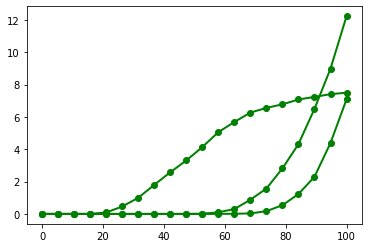

In [10]:
print(np.percentile(Und_L2['Clean'],95))

for adversary in adversary_dict.keys():
    if(adversary!='Clean'):
        x = np.linspace(0, 100, 20)
#         z = np.array([np.sum(Und_L2['Clean']>((i_x/100))*(np.percentile(Und_L2['Clean'],95)*2)).item()/100 for i_x in x])
        y = np.array([np.sum(Und_L2[adversary]<=((i_x/100))*(np.percentile(Und_L2['Clean'],95)*2)).item()/100 for i_x in x])
        plt.plot(x, y, 'go-', label='line1', linewidth=2)

In [11]:
Und_L2_Untargeted_Capsnet = Und_L2
print('theta-----------percentile----Clean--------------FGSM------------BIM------------PGD')
for i in range(0,101):
    Attack_Table(Und_L2, i)

theta-----------percentile----Clean--------------FGSM------------BIM------------PGD
1.702603816986084 : 0     100.0 / 0.01 ---- 7.67 / 0.0 ---- 99.9 / 0.0 ---- 99.88 / 0.0
3.816179938316345 : 1     100.0 / 1.0 ---- 7.67 / 0.0 ---- 99.9 / 0.0 ---- 99.88 / 0.0
4.287732286453247 : 2     100.0 / 2.0 ---- 7.67 / 0.0 ---- 99.9 / 0.0 ---- 99.88 / 0.0
4.706228923797608 : 3     100.0 / 3.0 ---- 7.67 / 0.0 ---- 99.9 / 0.0 ---- 99.88 / 0.0
5.059421787261964 : 4     100.0 / 4.0 ---- 7.67 / 0.0 ---- 99.9 / 0.0 ---- 99.88 / 0.0
5.45211238861084 : 5     100.0 / 5.0 ---- 7.67 / 0.0 ---- 99.9 / 0.0 ---- 99.88 / 0.0
5.836243057250977 : 6     100.0 / 6.0 ---- 7.67 / 0.0 ---- 99.9 / 0.0 ---- 99.88 / 0.0
6.295203762054443 : 7     100.0 / 7.0 ---- 7.67 / 0.0 ---- 99.9 / 0.0 ---- 99.88 / 0.0
6.593488502502441 : 8     100.0 / 8.0 ---- 7.67 / 0.0 ---- 99.9 / 0.0 ---- 99.88 / 0.0
7.071027097702026 : 9     100.0 / 9.0 ---- 7.67 / 0.0 ---- 99.9 / 0.0 ---- 99.88 / 0.0
7.578047370910646 : 10     100.0 / 10.0 ---- 7

In [13]:
model_for_adversary = Model_for_Adversary(net)
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=100, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=100, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

Success_Rate, Undetected_Rate, Und_L2 = WhiteBox_Attacks_Targeted(net, testloader, adversary_dict, args)

100%|██████████| 20/20 [36:17<00:00, 108.90s/it]


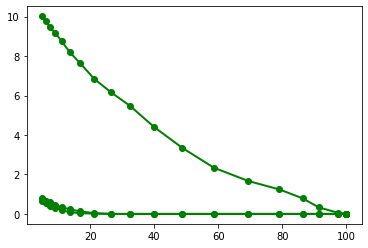

In [14]:
for adversary in adversary_dict.keys():
    if(adversary!='Clean'):
        x = np.linspace(0, 100, 20)
        z = np.array([np.sum(Und_L2['Clean']>((i_x/100))*((np.percentile(Und_L2['Clean'],95)))).item()/100 for i_x in x])
        y = np.array([np.sum(Und_L2[adversary]<=((i_x/100))*((np.percentile(Und_L2['Clean'],95)))).item()/100 for i_x in x])
        plt.plot(z, y, 'go-', label='line1', linewidth=2)

In [15]:
Und_L2_Targeted_Capsnet = Und_L2
for i in range(0,100):
    Attack_Table(Und_L2, i)

1.702603816986084 : 0     100.0 / 0.01 ---- 11.38 / 0.0 ---- 99.98 / 0.0 ---- 100.0 / 0.0
3.816179938316345 : 1     100.0 / 1.0 ---- 11.38 / 0.01 ---- 99.98 / 0.0 ---- 100.0 / 0.0
4.287732286453247 : 2     100.0 / 2.0 ---- 11.38 / 0.03 ---- 99.98 / 0.0 ---- 100.0 / 0.0
4.706228923797608 : 3     100.0 / 3.0 ---- 11.38 / 0.06 ---- 99.98 / 0.0 ---- 100.0 / 0.0
5.059421787261964 : 4     100.0 / 4.0 ---- 11.38 / 0.11 ---- 99.98 / 0.0 ---- 100.0 / 0.0
5.45211238861084 : 5     100.0 / 5.0 ---- 11.38 / 0.12 ---- 99.98 / 0.0 ---- 100.0 / 0.0
5.836243057250977 : 6     100.0 / 6.0 ---- 11.38 / 0.15 ---- 99.98 / 0.0 ---- 100.0 / 0.0
6.295203762054443 : 7     100.0 / 7.0 ---- 11.38 / 0.18 ---- 99.98 / 0.0 ---- 100.0 / 0.0
6.593488502502441 : 8     100.0 / 8.0 ---- 11.38 / 0.24 ---- 99.98 / 0.0 ---- 100.0 / 0.0
7.071027097702026 : 9     100.0 / 9.0 ---- 11.38 / 0.36 ---- 99.98 / 0.0 ---- 100.0 / 0.0
7.578047370910646 : 10     100.0 / 10.0 ---- 11.38 / 0.48 ---- 99.98 / 0.0 ---- 100.0 / 0.0
8.0652588

In [16]:
np.save('Und_L2_Targeted_Capsnet.npy', Und_L2_Targeted_Capsnet)
# np.save('Und_L2_Untargeted_Capsnet.npy', Und_L2_Untargeted_Capsnet)

## Histograms for CNN + CR

In [13]:
args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 256,
    'N_EPOCHS': 100,
    'LEARNING_RATE_1': 1e-2,
    'LEARNING_RATE_2': 1e-2,
    'WEIGHTDECAY':5e-6,
    
    #Scheduler
    'USE_SCHEDULER':True,
    'sched_milestones':[8,20,30,40,50],
    'sched_gamma':0.1,
    
    #Loss Function
    'LAMBDA_recon': 0.5,
    'LAMBDA_class': 1,
    
    #For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusCR',
    
}

In [14]:
class Config:
    def __init__(self, dataset='mnist'):
        # CONV1
        self.conv1_in = 1
        self.conv1_out = 12
        self.conv1_kernel_size = 15

        # CONV2
        self.conv2_in = 12
        self.conv2_out = 16
        self.conv2_kernel_size = 8

        # FC1
        self.fc1_in = 7 * 7 * 16
        self.fc1_out = 784
        
        # FC1
        self.fc2_in = 784
        self.fc2_out = 160

torch.manual_seed(2)
config = Config()

net = CNNnet(args, config)

# net = torch.nn.DataParallel(net)
net.load_state_dict(torch.load(os.path.join(model_path, 'CNNplusCR_mnist.pth'), map_location='cpu'))
    
if args['USE_CUDA']:
    net = net.cuda()
    

In [15]:
import matplotlib.pyplot as plt
from advertorch.attacks import LinfPGDAttack, GradientSignAttack, CarliniWagnerL2Attack, LinfBasicIterativeAttack

class Model_for_Adversary(nn.Module):
    def __init__(self, net):
        super(Model_for_Adversary, self).__init__()
        self.net = net
        
    def forward(self, x):
        output, recons, masked = self.net(x)
        classes = output.sum(2)
        return classes


In [16]:
from advertorch.attacks.base import Attack, LabelMixin
from advertorch.utils import clamp

class CleanAttack(Attack, LabelMixin):
    def __init__(self, clip_min=0., clip_max=1.):
        super(CleanAttack, self).__init__(None, None, clip_min, clip_max)
        self.clip_min = clip_min
        self.clip_max = clip_max
        self.targeted = False

    def perturb(self, x, y=None):
        return x
    
model_for_adversary = Model_for_Adversary(net)
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

Success_Rate, Undetected_Rate, Und_L2 = WhiteBox_Attacks_Untargeted(net, testloader, adversary_dict, args)

100%|██████████| 40/40 [06:30<00:00,  9.77s/it]


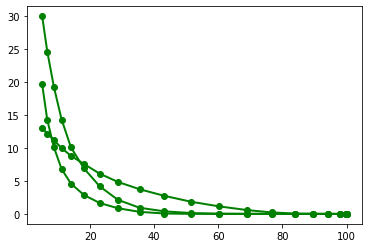

In [17]:
Und_L2_Untargeted_plusCR = Und_L2
for adversary in adversary_dict.keys():
    if(adversary!='Clean'):
        x = np.linspace(0, 100, 20)
        z = np.array([np.sum(Und_L2['Clean']>((i_x/100))*(np.percentile(Und_L2['Clean'],95))).item()/100 for i_x in x])
        y = np.array([np.sum(Und_L2[adversary]<=((i_x/100))*(np.percentile(Und_L2['Clean'],95))).item()/100 for i_x in x])
        plt.plot(z, y, 'go-', label='line1', linewidth=2)

In [18]:
for i in range(0,100):
    Attack_Table(Und_L2, i)

2.7748494148254395 : 0     100.0 / 0.01 ---- 17.31 / 0.0 ---- 82.47 / 0.0 ---- 95.49 / 0.0
8.515503749847412 : 1     100.0 / 1.0 ---- 17.31 / 0.0 ---- 82.47 / 0.0 ---- 95.49 / 0.0
10.07335475921631 : 2     100.0 / 2.0 ---- 17.31 / 0.0 ---- 82.47 / 0.0 ---- 95.49 / 0.0
11.545774812698363 : 3     100.0 / 3.0 ---- 17.31 / 0.0 ---- 82.47 / 0.0 ---- 95.49 / 0.0
13.100052185058596 : 4     100.0 / 4.0 ---- 17.31 / 0.0 ---- 82.47 / 0.0 ---- 95.49 / 0.0
14.224604558944703 : 5     100.0 / 5.0 ---- 17.31 / 0.0 ---- 82.47 / 0.0 ---- 95.49 / 0.0
15.400445003509521 : 6     100.0 / 6.0 ---- 17.31 / 0.0 ---- 82.47 / 0.0 ---- 95.49 / 0.0
16.460757083892823 : 7     100.0 / 7.0 ---- 17.31 / 0.01 ---- 82.47 / 0.0 ---- 95.49 / 0.0
17.64835594177246 : 8     100.0 / 8.0 ---- 17.31 / 0.01 ---- 82.47 / 0.0 ---- 95.49 / 0.0
18.751493473052978 : 9     100.0 / 9.0 ---- 17.31 / 0.01 ---- 82.47 / 0.0 ---- 95.49 / 0.0
19.8048828125 : 10     100.0 / 10.0 ---- 17.31 / 0.03 ---- 82.47 / 0.0 ---- 95.49 / 0.0
20.68039897

In [19]:
model_for_adversary = Model_for_Adversary(net)
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

Success_Rate, Undetected_Rate, Und_L2 = WhiteBox_Attacks_Targeted(net, testloader, adversary_dict, args)

100%|██████████| 40/40 [06:32<00:00,  9.82s/it]


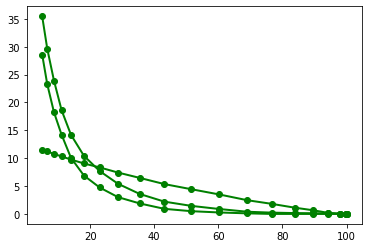

In [20]:
Und_L2_Targeted_plusCR = Und_L2
for adversary in adversary_dict.keys():
    if(adversary!='Clean'):
        x = np.linspace(0, 100, 20)
        z = np.array([np.sum(Und_L2['Clean']>((i_x/100))*(np.percentile(Und_L2['Clean'],95))).item()/100 for i_x in x])
        y = np.array([np.sum(Und_L2[adversary]<=((i_x/100))*(np.percentile(Und_L2['Clean'],95))).item()/100 for i_x in x])
        plt.plot(z, y, 'go-', label='line1', linewidth=2)

In [21]:
for i in range(0,100):
    Attack_Table(Und_L2, i)

2.7748494148254395 : 0     100.0 / 0.01 ---- 12.86 / 0.0 ---- 81.42 / 0.0 ---- 79.28 / 0.0
8.515503749847412 : 1     100.0 / 1.0 ---- 12.86 / 0.02 ---- 81.42 / 0.0 ---- 79.28 / 0.0
10.07335475921631 : 2     100.0 / 2.0 ---- 12.86 / 0.07 ---- 81.42 / 0.01 ---- 79.28 / 0.0
11.545774812698363 : 3     100.0 / 3.0 ---- 12.86 / 0.1 ---- 81.42 / 0.02 ---- 79.28 / 0.0
13.100052185058596 : 4     100.0 / 4.0 ---- 12.86 / 0.13 ---- 81.42 / 0.02 ---- 79.28 / 0.0
14.224604558944703 : 5     100.0 / 5.0 ---- 12.86 / 0.16 ---- 81.42 / 0.07 ---- 79.28 / 0.0
15.400445003509521 : 6     100.0 / 6.0 ---- 12.86 / 0.21 ---- 81.42 / 0.1 ---- 79.28 / 0.0
16.460757083892823 : 7     100.0 / 7.0 ---- 12.86 / 0.31 ---- 81.42 / 0.11 ---- 79.28 / 0.0
17.64835594177246 : 8     100.0 / 8.0 ---- 12.86 / 0.38 ---- 81.42 / 0.11 ---- 79.28 / 0.0
18.751493473052978 : 9     100.0 / 9.0 ---- 12.86 / 0.5 ---- 81.42 / 0.11 ---- 79.28 / 0.0
19.8048828125 : 10     100.0 / 10.0 ---- 12.86 / 0.62 ---- 81.42 / 0.11 ---- 79.28 / 0.0

In [19]:
np.save('Und_L2_Targeted_plusCR.npy', Und_L2_Targeted_plusCR)
np.save('Und_L2_Untargeted_plusCR.npy', Und_L2_Untargeted_plusCR)

## Histograms for CNN plus R

In [22]:
args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 256,
    'N_EPOCHS': 100,
    'LEARNING_RATE_1': 1e-2,
    'LEARNING_RATE_2': 1e-2,
    'WEIGHTDECAY':5e-6,
    
    #Scheduler
    'USE_SCHEDULER':True,
    'sched_milestones':[8,20,30,40,50],
    'sched_gamma':0.1,
    
    #Loss Function
    'LAMBDA_recon': 0.5,
    'LAMBDA_class': 1,
    
    #For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusR',
    
}

In [23]:
class Config:
    def __init__(self, dataset='mnist'):
        # CONV1
        self.conv1_in = 1
        self.conv1_out = 12
        self.conv1_kernel_size = 15

        # CONV2
        self.conv2_in = 12
        self.conv2_out = 16
        self.conv2_kernel_size = 8

        # FC1
        self.fc1_in = 7 * 7 * 16
        self.fc1_out = 784
        
        # FC1
        self.fc2_in = 784
        self.fc2_out = 160

torch.manual_seed(2)
config = Config()

net = CNNnet(args, config)

# net = torch.nn.DataParallel(net)
net.load_state_dict(torch.load(os.path.join(model_path, 'CNNplusR_mnist.pth'), map_location='cpu'))
    
if args['USE_CUDA']:
    net = net.cuda()
    

In [24]:
model_for_adversary = Model_for_Adversary(net)
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

Success_Rate, Undetected_Rate, Und_L2 = WhiteBox_Attacks_Untargeted(net, testloader, adversary_dict, args)

100%|██████████| 40/40 [06:33<00:00,  9.84s/it]


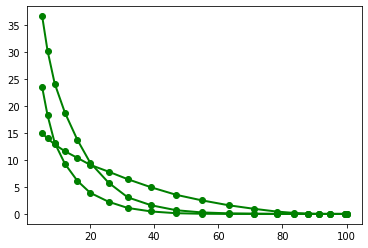

In [25]:
Und_L2_Untargeted_plusR = Und_L2
for adversary in adversary_dict.keys():
    if(adversary!='Clean'):
        x = np.linspace(0, 100, 20)
        z = np.array([np.sum(Und_L2['Clean']>((i_x/100))*(np.percentile(Und_L2['Clean'],95))).item()/100 for i_x in x])
        y = np.array([np.sum(Und_L2[adversary]<=((i_x/100))*(np.percentile(Und_L2['Clean'],95))).item()/100 for i_x in x])
        plt.plot(z, y, 'go-', label='line1', linewidth=2)

In [26]:
for i in range(0,100):
    Attack_Table(Und_L2, i)

2.129915475845337 : 0     100.0 / 0.01 ---- 17.93 / 0.0 ---- 87.42 / 0.0 ---- 95.98 / 0.0
5.590077862739563 : 1     100.0 / 1.0 ---- 17.93 / 0.0 ---- 87.42 / 0.0 ---- 95.98 / 0.0
6.821305723190307 : 2     100.0 / 2.0 ---- 17.93 / 0.0 ---- 87.42 / 0.0 ---- 95.98 / 0.0
7.850012111663817 : 3     100.0 / 3.0 ---- 17.93 / 0.0 ---- 87.42 / 0.0 ---- 95.98 / 0.0
8.832404708862306 : 4     100.0 / 4.0 ---- 17.93 / 0.0 ---- 87.42 / 0.0 ---- 95.98 / 0.0
9.799595785140992 : 5     100.0 / 5.0 ---- 17.93 / 0.0 ---- 87.42 / 0.0 ---- 95.98 / 0.0
10.85278694152832 : 6     100.0 / 6.0 ---- 17.93 / 0.0 ---- 87.42 / 0.0 ---- 95.98 / 0.0
12.149410057067874 : 7     100.0 / 7.0 ---- 17.93 / 0.0 ---- 87.42 / 0.0 ---- 95.98 / 0.0
13.675243301391603 : 8     100.0 / 8.0 ---- 17.93 / 0.0 ---- 87.42 / 0.0 ---- 95.98 / 0.0
15.290825796127319 : 9     100.0 / 9.0 ---- 17.93 / 0.01 ---- 87.42 / 0.0 ---- 95.98 / 0.0
17.03084487915039 : 10     100.0 / 10.0 ---- 17.93 / 0.02 ---- 87.42 / 0.0 ---- 95.98 / 0.0
18.4766983795

88.53247528076172 : 93     100.0 / 93.0 ---- 17.93 / 13.74 ---- 87.42 / 29.29 ---- 95.98 / 17.35
91.25075576782226 : 94     100.0 / 94.0 ---- 17.93 / 14.38 ---- 87.42 / 32.66 ---- 95.98 / 20.21
94.30052337646474 : 95     100.0 / 95.0 ---- 17.93 / 14.91 ---- 87.42 / 36.57 ---- 95.98 / 23.44
98.00491394042967 : 96     100.0 / 96.0 ---- 17.93 / 15.4 ---- 87.42 / 41.47 ---- 95.98 / 28.19
101.75148056030258 : 97     100.0 / 97.0 ---- 17.93 / 15.94 ---- 87.42 / 46.41 ---- 95.98 / 33.19
108.26952377319338 : 98     100.0 / 98.0 ---- 17.93 / 16.62 ---- 87.42 / 53.89 ---- 95.98 / 42.36
116.92753837585452 : 99     100.0 / 99.0 ---- 17.93 / 17.1 ---- 87.42 / 62.81 ---- 95.98 / 55.52


In [27]:
model_for_adversary = Model_for_Adversary(net)
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

Success_Rate, Undetected_Rate, Und_L2 = WhiteBox_Attacks_Targeted(net, testloader, adversary_dict, args)

100%|██████████| 40/40 [06:35<00:00,  9.88s/it]


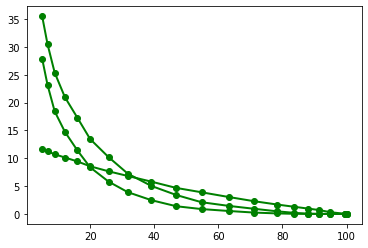

In [28]:
Und_L2_Targeted_plusR = Und_L2
for adversary in adversary_dict.keys():
    if(adversary!='Clean'):
        x = np.linspace(0, 100, 20)
        z = np.array([np.sum(Und_L2['Clean']>((i_x/100))*(np.percentile(Und_L2['Clean'],95))).item()/100 for i_x in x])
        y = np.array([np.sum(Und_L2[adversary]<=((i_x/100))*(np.percentile(Und_L2['Clean'],95))).item()/100 for i_x in x])
        plt.plot(z, y, 'go-', label='line1', linewidth=2)

In [29]:
for i in range(0,100):
    Attack_Table(Und_L2, i)

2.129915475845337 : 0     100.0 / 0.01 ---- 12.77 / 0.0 ---- 67.43 / 0.0 ---- 63.28 / 0.0
5.590077862739563 : 1     100.0 / 1.0 ---- 12.77 / 0.05 ---- 67.43 / 0.0 ---- 63.28 / 0.0
6.821305723190307 : 2     100.0 / 2.0 ---- 12.77 / 0.11 ---- 67.43 / 0.0 ---- 63.28 / 0.0
7.850012111663817 : 3     100.0 / 3.0 ---- 12.77 / 0.19 ---- 67.43 / 0.0 ---- 63.28 / 0.0
8.832404708862306 : 4     100.0 / 4.0 ---- 12.77 / 0.25 ---- 67.43 / 0.0 ---- 63.28 / 0.0
9.799595785140992 : 5     100.0 / 5.0 ---- 12.77 / 0.32 ---- 67.43 / 0.0 ---- 63.28 / 0.0
10.85278694152832 : 6     100.0 / 6.0 ---- 12.77 / 0.41 ---- 67.43 / 0.0 ---- 63.28 / 0.0
12.149410057067874 : 7     100.0 / 7.0 ---- 12.77 / 0.53 ---- 67.43 / 0.0 ---- 63.28 / 0.0
13.675243301391603 : 8     100.0 / 8.0 ---- 12.77 / 0.64 ---- 67.43 / 0.0 ---- 63.28 / 0.0
15.290825796127319 : 9     100.0 / 9.0 ---- 12.77 / 0.72 ---- 67.43 / 0.01 ---- 63.28 / 0.0
17.03084487915039 : 10     100.0 / 10.0 ---- 12.77 / 0.83 ---- 67.43 / 0.01 ---- 63.28 / 0.0
18.

In [31]:
# np.save('Und_L2_Targeted_plusR.npy', Und_L2_Targeted_plusR)
# np.save('Und_L2_Untargeted_plusR.npy', Und_L2_Untargeted_plusR)

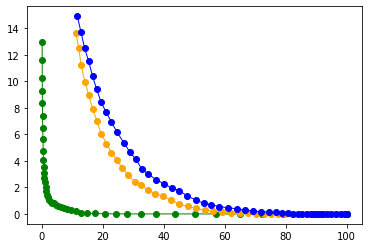

In [24]:

def plot_Ud_FPR(adversary, Und_L2_list):
    color_list = ['green', 'orange','blue']
    model_list = ['CapsNet', 'plusCR', 'plusR']
    for i,Und_L2 in enumerate(Und_L2_list):
        if(adversary!='Clean'):
            x = np.linspace(0, 100, 50)
#             z = np.array([((1 - i_x/100))*(np.percentile(Und_L2['Clean'],95)*2).item() for i_x in x])
#             z = np.array([np.sum(Und_L2['Clean']>((i_x/100))*(np.percentile(Und_L2['Clean'],100))).item()/100 for i_x in x])
#             y = np.array([np.sum(Und_L2[adversary]<=((i_x/100))*(np.percentile(Und_L2['Clean'],100))).item()/100 for i_x in x])
            z = np.array([np.sum(Und_L2['Clean']>((i_x/100))*(80)).item()/100 for i_x in x])
            y = np.array([np.sum(Und_L2[adversary]<=((i_x/100))*(80)).item()/100 for i_x in x])
            plt.plot(z, y,color=color_list[i], linestyle='-', marker='o', label=model_list[i], linewidth=1)
            
plot_Ud_FPR('PGD',[Und_L2_Targeted_Capsnet,Und_L2_Targeted_plusCR,Und_L2_Targeted_plusR])

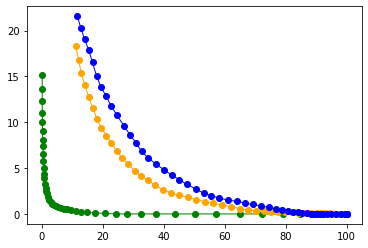

In [25]:
plot_Ud_FPR('BIM',[Und_L2_Targeted_Capsnet,Und_L2_Targeted_plusCR,Und_L2_Targeted_plusR])

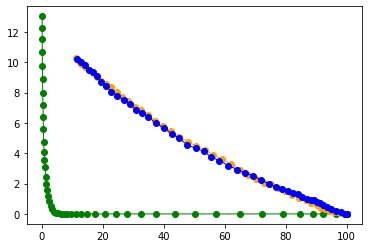

In [26]:
plot_Ud_FPR('FGSM',[Und_L2_Targeted_Capsnet,Und_L2_Targeted_plusCR,Und_L2_Targeted_plusR])

In [31]:
Und_L2_Targeted_Capsnet = np.load('Und_L2_Targeted_Capsnet.npy', allow_pickle=True).item()
Und_L2_Untargeted_Capsnet = np.load('Und_L2_Untargeted_Capsnet.npy', allow_pickle=True).item()

# Und_L2_Targeted_plusCR = np.load('Und_L2_Targeted_plusCR.npy', allow_pickle=True).item()
# Und_L2_Untargeted_plusCR = np.load('Und_L2_Untargeted_plusCR.npy', allow_pickle=True).item()

# Und_L2_Targeted_plusR = np.load('Und_L2_Targeted_plusR.npy', allow_pickle=True).item()
# Und_L2_Untargeted_plusR = np.load('Und_L2_Untargeted_plusR.npy', allow_pickle=True).item()


In [32]:
from tabulate import tabulate

def Print_Table(Und_L2_dict, percentile=95, theta=None):
    print('Percentile :', percentile)
    table = []
    for network in Und_L2_dict.keys():
        if theta is None:
            theta = np.percentile(Und_L2_dict[network]['Clean'], percentile)
        else:
            theta = theta
        Success_Rate = {key:0.0 for key in Und_L2_dict[network].keys()}
        Undetected_Rate = {key:0.0 for key in Und_L2_dict[network].keys()}
        for adversary in Und_L2_dict[network].keys():
            Success_Rate[adversary] = Und_L2_dict[network][adversary].shape[0]/ 100
            Undetected_Rate[adversary] = np.sum(Und_L2_dict[network][adversary]<=theta).item()/100
        table.append([network, str(Success_Rate['FGSM'])+"/"+str(Undetected_Rate['FGSM']),str(Success_Rate['BIM'])+"/"+str(Undetected_Rate['BIM']),str(Success_Rate['PGD'])+"/"+str(Undetected_Rate['PGD'])])
    print(tabulate(table, headers=['Networks', 'FGSM', 'BIM', 'PGD']))

Und_L2_dict = {'CapsNet':Und_L2_Untargeted_Capsnet, 'CNN+CR':Und_L2_Untargeted_plusCR, 'CNN+R':Und_L2_Untargeted_plusR}
Print_Table(Und_L2_dict)

Percentile : 95
Networks    FGSM        BIM         PGD
----------  ----------  ----------  ----------
CapsNet     7.67/3.7    99.9/0.0    99.88/0.0
CNN+CR      17.31/1.63  82.47/0.11  95.49/0.01
CNN+R       17.93/2.3   87.42/0.21  95.98/0.02


In [33]:
Und_L2_dict = {'CapsNet':Und_L2_Targeted_Capsnet, 'CNN+CR':Und_L2_Targeted_plusCR, 'CNN+R':Und_L2_Targeted_plusR}
Print_Table(Und_L2_dict)

Percentile : 95
Networks    FGSM         BIM         PGD
----------  -----------  ----------  ----------
CapsNet     11.38/10.02  99.98/0.83  100.0/0.64
CNN+CR      12.86/4.11   81.42/1.27  79.28/0.41
CNN+R       12.77/3.68   67.43/1.89  63.28/0.77


In [6]:
Und_L2_dict = {'CapsNet':Und_L2_Untargeted_Capsnet, 'CNN+CR':Und_L2_Untargeted_plusCR, 'CNN+R':Und_L2_Untargeted_plusR}
Print_Table(Und_L2_dict, theta=45)

Percentile : 95
Networks    FGSM        BIM         PGD
----------  ----------  ----------  ----------
CapsNet     76.63/0.07  99.9/0.01   99.94/0.0
CNN+CR      17.31/1.83  82.47/0.13  95.47/0.03
CNN+R       17.93/2.56  87.42/0.29  95.74/0.02


In [7]:
Und_L2_dict = {'CapsNet':Und_L2_Targeted_Capsnet, 'CNN+CR':Und_L2_Targeted_plusCR, 'CNN+R':Und_L2_Targeted_plusR}
Print_Table(Und_L2_dict, theta=45)

Percentile : 95
Networks    FGSM        BIM         PGD
----------  ----------  ----------  ----------
CapsNet     22.54/0.11  99.98/0.91  100.0/0.75
CNN+CR      12.86/4.43  81.42/1.41  79.11/0.36
CNN+R       12.77/3.96  67.45/2.12  63.05/0.78
